# **Computational Drug Discovery [Part 2]: Exploratory Data Analysis**

Based on tutorial by Chanin Nantasenamat, [*'Data Professor' YouTube channel*](http://youtube.com/dataprofessor)

In **Part 2**, we will be performing Descriptor Calculation and Exploratory Data Analysis.

---

## **Install conda and rdkit**

In [51]:
! pip install rdkit
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [52]:
# ! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
# ! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
# ! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
# ! conda install -c rdkit rdkit -y
# import sys
# sys.path.append('/usr/local/lib/python3.7/site-packages/')

## **Load bioactivity data**

In [53]:
import pandas as pd

In [ ]:
df_preprocessed = pd.read_csv('./data/bioactivity_preprocessed_data.csv')
df_preprocessed

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,active
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,active
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,inactive
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,active
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,active
...,...,...,...,...
8125,CHEMBL5398421,COc1cc(O)c2c(c1)C(=O)c1cc(O)c(O)cc1CCN2,46000.0,inactive
8126,CHEMBL11298,N[C@@H](CO)C(=O)O,38310.0,inactive
8127,CHEMBL5395312,CN1CCN(c2ccc(C(=O)Nc3cc(-c4nc5ccccc5[nH]4)n[nH...,1710.0,intermediate
8128,CHEMBL5399112,O=C(Nc1cc(-c2nc3ccccc3[nH]2)n[nH]1)c1ccc(N2CCN...,10000.0,inactive


Clean the smiles data by removing salts/ions that are attached to the molecule, separated from the molecule by '.'. Of the multiple resulting compounds after splitting, we will assume the lrgest compund is the molecule of interest.

In [55]:
# remove NaNs in canonical_smiles
s = 0
df_smile_preprocessed = df_preprocessed
for i in df_preprocessed.canonical_smiles:
    if type(i) == float:
        print(i, s)
        df_smile_preprocessed = df_smile_preprocessed.drop(s, axis=0)
    s+=1
df_smile_preprocessed = df_smile_preprocessed.reset_index(drop=True) #drop T == dnot save original index # in a new col
df_smile_preprocessed


clean_smiles = []
for i in df_smile_preprocessed.canonical_smiles.tolist():
    compounds = str(i).split('.')
    longest_compound= max(compounds, key=len) # max length element after splitting compounds 
    clean_smiles.append(longest_compound)
clean_smiles = pd.Series(clean_smiles, name = 'canonical_smiles') # series = 1D array w label
df_clean_smiles = pd.concat([df_smile_preprocessed.drop(columns='canonical_smiles'), clean_smiles], axis=1)
df_clean_smiles

nan 1850
nan 1966


,molecule_chembl_id,standard_value,bioactivity_class,canonical_smiles
0,CHEMBL133897,750.0,active,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1
1,CHEMBL336398,100.0,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1
2,CHEMBL131588,50000.0,inactive,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1
3,CHEMBL130628,300.0,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F
4,CHEMBL130478,800.0,active,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C
...,...,...,...,...
8123,CHEMBL5398421,46000.0,inactive,COc1cc(O)c2c(c1)C(=O)c1cc(O)c(O)cc1CCN2
8124,CHEMBL11298,38310.0,inactive,N[C@@H](CO)C(=O)O
8125,CHEMBL5395312,1710.0,intermediate,CN1CCN(c2ccc(C(=O)Nc3cc(-c4nc5ccccc5[nH]4)n[nH...
8126,CHEMBL5399112,10000.0,inactive,O=C(Nc1cc(-c2nc3ccccc3[nH]2)n[nH]1)c1ccc(N2CCN...


## **Calculate Lipinski descriptors**
Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the **druglikeness** of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the **Rule-of-Five** (all values are multiples of five) or **Lipinski's Rule**.

The Lipinski's Rule stated the following:
* Molecular weight < 500 Dalton
* Octanol-water partition coefficient (LogP) < 5
* Hydrogen bond donors < 5
* Hydrogen bond acceptors < 10 

### **Import libraries**

In [56]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

### **Calculate descriptors**
Input 'SMILES' notation of chemical information --> tells us exact atomic details of the molecule, from which we compute molecular descriptors

SMILES: Simplified Molecular Input Line Entry System; ASCII strings for line notation of chemical's structure

In [57]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) # returns RDKit molecule object based on SMILES string
        moldata.append(mol)
       
    baseData= np.arange(1,1) # create empty numpy array (based on range (1,1) = [])
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        # store molecule's descriptors together as 1D array
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row]) # vertical stacking of new array element (row) to priors (baseData) --> 2D array object 
        i=i+1      
    
    #save lipinski rule array into a df 
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [58]:

df_lipinski = lipinski(df_clean_smiles.canonical_smiles)

### **Combine DataFrames**

Let's take a look at the 2 DataFrames that will be combined.

In [59]:
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,312.325,2.8032,0.0,6.0
1,376.913,4.5546,0.0,5.0
2,426.851,5.3574,0.0,5.0
3,404.845,4.7069,0.0,5.0
4,346.334,3.0953,0.0,6.0
...,...,...,...,...
8123,301.298,2.0110,4.0,6.0
8124,105.093,-1.6094,3.0,3.0
8125,401.474,2.9571,3.0,5.0
8126,387.447,2.6149,4.0,5.0


In [60]:
df_clean_smiles

,molecule_chembl_id,standard_value,bioactivity_class,canonical_smiles
0,CHEMBL133897,750.0,active,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1
1,CHEMBL336398,100.0,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1
2,CHEMBL131588,50000.0,inactive,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1
3,CHEMBL130628,300.0,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F
4,CHEMBL130478,800.0,active,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C
...,...,...,...,...
8123,CHEMBL5398421,46000.0,inactive,COc1cc(O)c2c(c1)C(=O)c1cc(O)c(O)cc1CCN2
8124,CHEMBL11298,38310.0,inactive,N[C@@H](CO)C(=O)O
8125,CHEMBL5395312,1710.0,intermediate,CN1CCN(c2ccc(C(=O)Nc3cc(-c4nc5ccccc5[nH]4)n[nH...
8126,CHEMBL5399112,10000.0,inactive,O=C(Nc1cc(-c2nc3ccccc3[nH]2)n[nH]1)c1ccc(N2CCN...


Now, let's combine the 2 DataFrame

In [61]:
df_combined = pd.concat([df_clean_smiles,df_lipinski], axis=1)

In [62]:
df_combined

,molecule_chembl_id,standard_value,bioactivity_class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL133897,750.0,active,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,312.325,2.8032,0.0,6.0
1,CHEMBL336398,100.0,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,376.913,4.5546,0.0,5.0
2,CHEMBL131588,50000.0,inactive,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,426.851,5.3574,0.0,5.0
3,CHEMBL130628,300.0,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,404.845,4.7069,0.0,5.0
4,CHEMBL130478,800.0,active,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,346.334,3.0953,0.0,6.0
...,...,...,...,...,...,...,...,...
8123,CHEMBL5398421,46000.0,inactive,COc1cc(O)c2c(c1)C(=O)c1cc(O)c(O)cc1CCN2,301.298,2.0110,4.0,6.0
8124,CHEMBL11298,38310.0,inactive,N[C@@H](CO)C(=O)O,105.093,-1.6094,3.0,3.0
8125,CHEMBL5395312,1710.0,intermediate,CN1CCN(c2ccc(C(=O)Nc3cc(-c4nc5ccccc5[nH]4)n[nH...,401.474,2.9571,3.0,5.0
8126,CHEMBL5399112,10000.0,inactive,O=C(Nc1cc(-c2nc3ccccc3[nH]2)n[nH]1)c1ccc(N2CCN...,387.447,2.6149,4.0,5.0


### **Convert IC50 to pIC50**
To allow **IC50** data to be more uniformly distributed, we will convert **IC50** to the negative logarithmic scale which is essentially **-log10(IC50)**.

This custom function pIC50() will accept a DataFrame as input and will:
* Take the IC50 values from the ``standard_value`` column and converts it from nM to M by multiplying the value by 10$^{-9}$
* Take the molar value and apply -log10
* Delete the ``standard_value`` column and create a new ``pIC50`` column

Point to note: Values greater than 100,000,000 will be fixed at 100,000,000 otherwise the negative logarithmic value will become negative.

In [63]:
df_combined.standard_value.describe()

count    8.128000e+03
mean     9.621716e+04
std      9.840917e+05
min      0.000000e+00
25%      1.000000e+02
50%      1.504500e+03
75%      1.240000e+04
max      5.000000e+07
Name: standard_value, dtype: float64

In [64]:
-np.log10( (10**-9)* 100000000 )

np.float64(1.0)

In [65]:
-np.log10( (10**-9)* 10000000000 )

np.float64(-1.0)

Therefore, we will first apply the norm_value() function so that the values in the standard_value column is normalized.

In [85]:
def norm_value(input_df):
  input_df = input_df[input_df['standard_value'] != 0]
  norm = []

  for ic50 in input_df['standard_value']:
    if ic50 > 100000000:
      ic50 = 100000000
    norm.append(ic50)

  input_df['standard_value_norm'] = norm
  input_df['standard_value']
  x = input_df.drop(columns='standard_value', axis=1)

  return x.reset_index(drop=True)

In [86]:
df_norm = norm_value(df_combined)
df_norm

C:\Users\liv_u\AppData\Local\Temp\ipykernel_7252\3163801115.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_df['standard_value_norm'] = norm


,molecule_chembl_id,bioactivity_class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL133897,active,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,312.325,2.8032,0.0,6.0,750.0
1,CHEMBL336398,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,376.913,4.5546,0.0,5.0,100.0
2,CHEMBL131588,inactive,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,426.851,5.3574,0.0,5.0,50000.0
3,CHEMBL130628,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,404.845,4.7069,0.0,5.0,300.0
4,CHEMBL130478,active,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,346.334,3.0953,0.0,6.0,800.0
...,...,...,...,...,...,...,...,...
8122,CHEMBL5398421,inactive,COc1cc(O)c2c(c1)C(=O)c1cc(O)c(O)cc1CCN2,301.298,2.0110,4.0,6.0,46000.0
8123,CHEMBL11298,inactive,N[C@@H](CO)C(=O)O,105.093,-1.6094,3.0,3.0,38310.0
8124,CHEMBL5395312,intermediate,CN1CCN(c2ccc(C(=O)Nc3cc(-c4nc5ccccc5[nH]4)n[nH...,401.474,2.9571,3.0,5.0,1710.0
8125,CHEMBL5399112,inactive,O=C(Nc1cc(-c2nc3ccccc3[nH]2)n[nH]1)c1ccc(N2CCN...,387.447,2.6149,4.0,5.0,10000.0


In [87]:
df_norm.standard_value_norm.describe()

count    8.127000e+03
mean     9.622900e+04
std      9.841517e+05
min      5.000000e-06
25%      1.000000e+02
50%      1.509000e+03
75%      1.240000e+04
max      5.000000e+07
Name: standard_value_norm, dtype: float64

In [92]:
# https://github.com/chaninlab/estrogen-receptor-alpha-qsar/blob/master/02_ER_alpha_RO5.ipynb

import numpy as np

def pIC50(input_df):
    pIC50 = []

    for i in input_df['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input_df['pIC50'] = pIC50
    x = input_df.drop(columns = 'standard_value_norm', axis = 1) # drop normalised standard_value column         
    return x

In [93]:
df_final = pIC50(df_norm)
df_final

,molecule_chembl_id,bioactivity_class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL133897,active,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,312.325,2.8032,0.0,6.0,6.124939
1,CHEMBL336398,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,376.913,4.5546,0.0,5.0,7.000000
2,CHEMBL131588,inactive,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,426.851,5.3574,0.0,5.0,4.301030
3,CHEMBL130628,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,404.845,4.7069,0.0,5.0,6.522879
4,CHEMBL130478,active,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,346.334,3.0953,0.0,6.0,6.096910
...,...,...,...,...,...,...,...,...
8122,CHEMBL5398421,inactive,COc1cc(O)c2c(c1)C(=O)c1cc(O)c(O)cc1CCN2,301.298,2.0110,4.0,6.0,4.337242
8123,CHEMBL11298,inactive,N[C@@H](CO)C(=O)O,105.093,-1.6094,3.0,3.0,4.416688
8124,CHEMBL5395312,intermediate,CN1CCN(c2ccc(C(=O)Nc3cc(-c4nc5ccccc5[nH]4)n[nH...,401.474,2.9571,3.0,5.0,5.767004
8125,CHEMBL5399112,inactive,O=C(Nc1cc(-c2nc3ccccc3[nH]2)n[nH]1)c1ccc(N2CCN...,387.447,2.6149,4.0,5.0,5.000000


In [94]:
df_final.pIC50.describe()

count    8127.000000
mean        5.960073
std         1.583841
min         1.301030
25%         4.906578
50%         5.821311
75%         7.000000
max        14.301030
Name: pIC50, dtype: float64

In [ ]:
df_final.to_csv('./data/acetylcholinesterase_bioactivity_3class_data.csv', index=False)

In [1]:
import pandas as pd
df_final = pd.read_csv('./data/acetylcholinesterase_bioactivity_3class_data.csv')

### **Removing the 'intermediate' bioactivity class**
Here, we will be removing the ``intermediate`` class from our data set.

In [2]:
df_2class = df_final[df_final['bioactivity_class'] != 'intermediate']
# df_2class=df_2class.reset_index()
df_2class

,molecule_chembl_id,bioactivity_class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL133897,active,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,312.325,2.8032,0.0,6.0,6.124939
1,CHEMBL336398,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,376.913,4.5546,0.0,5.0,7.000000
2,CHEMBL131588,inactive,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,426.851,5.3574,0.0,5.0,4.301030
3,CHEMBL130628,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,404.845,4.7069,0.0,5.0,6.522879
4,CHEMBL130478,active,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,346.334,3.0953,0.0,6.0,6.096910
...,...,...,...,...,...,...,...,...
8121,CHEMBL5435795,inactive,O=Cc1ccc2n1CCc1cc(O)c(O)cc1C2,243.262,1.8587,2.0,4.0,4.233810
8122,CHEMBL5398421,inactive,COc1cc(O)c2c(c1)C(=O)c1cc(O)c(O)cc1CCN2,301.298,2.0110,4.0,6.0,4.337242
8123,CHEMBL11298,inactive,N[C@@H](CO)C(=O)O,105.093,-1.6094,3.0,3.0,4.416688
8125,CHEMBL5399112,inactive,O=C(Nc1cc(-c2nc3ccccc3[nH]2)n[nH]1)c1ccc(N2CCN...,387.447,2.6149,4.0,5.0,5.000000


In [3]:
df_2class.to_csv('./data/acetylcholinesterase_bioactivity_2class_data.csv')

---

## **Exploratory Data Analysis (Chemical Space Analysis) via Lipinski descriptors**

In drug discovery, exploratory data analysis = 'Chemical Space Analysis'. Think of it as a chemical universe, with each compound as stars. Active molecules will have a larger size than inactive molecules, and can be thought of as constellations. 

### **Import library**

In [4]:
import seaborn as sns
sns.set_theme(style='ticks')
import matplotlib.pyplot as plt

In [6]:
%%bash
mkdir ./data/Part_2_Results

### **Frequency plot of the 2 bioactivity classes**

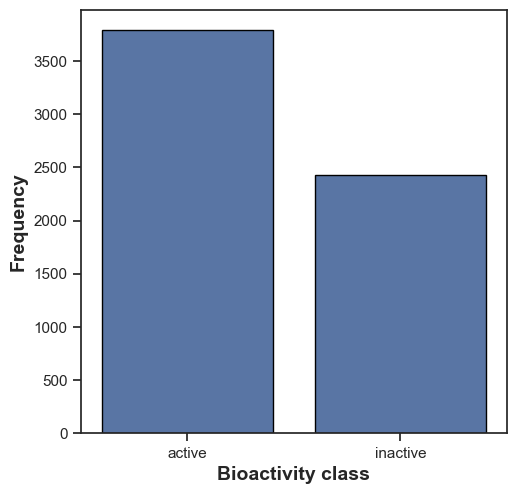

In [7]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='bioactivity_class', data=df_2class, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('./data/Part_2_Results/plot_bioactivity_class.pdf')

### **Scatter plot of MW versus LogP**

It can be seen that the 2 bioactivity classes are spanning similar chemical spaces as evident by the scatter plot of MW vs LogP.

In [8]:
# df_2classMW = df_2class.MW.dropna()
# df_2classMW

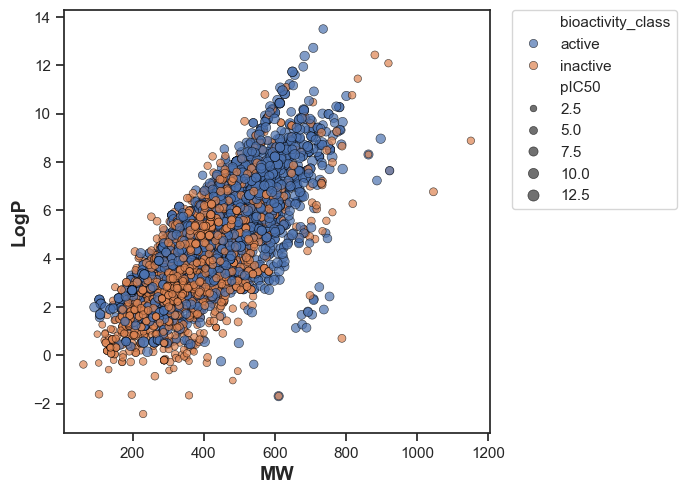

In [9]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='bioactivity_class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
# plt.show()
plt.savefig('./data/Part_2_Results/plot_MW_vs_LogP.pdf')

### **Box plots**

#### **pIC50 value**

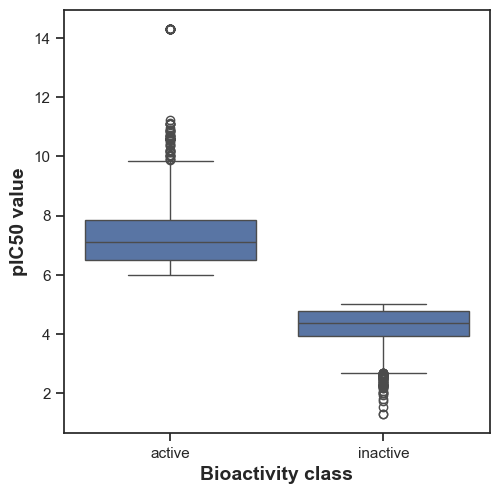

In [10]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'pIC50', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('./data/Part_2_Results/plot_ic50.pdf')

**Statistical analysis | Mann-Whitney U Test**

This is a non-parametric t-test for comparing *2 unpaired groups* that are *not normally distributed*. It compares using ranked order instead of group means.

In [11]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# active and inactive
  selection = [descriptor, 'bioactivity_class'] # descriptor vs bioactivity_class
  df = df_2class[selection]

  active = df[df.bioactivity_class == 'active']
  active = active[descriptor]

  inactive = df[df.bioactivity_class == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv('./data/Part_2_Results/'+filename)

  return results

In [12]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,9203184.0,0.0,0.05,Different distribution (reject H0)


#### **MW**

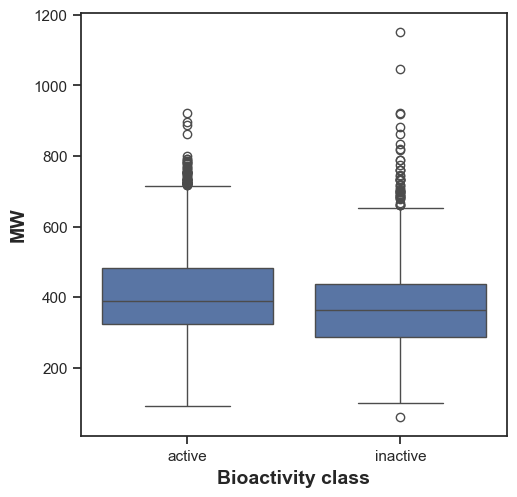

In [13]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'MW', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('./data/Part_2_Results/plot_MW.pdf')

In [14]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,5382804.5,1.156564e-29,0.05,Different distribution (reject H0)


#### **LogP**

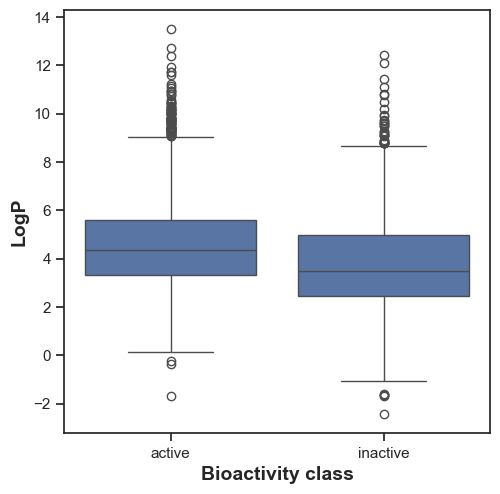

In [15]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'LogP', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('./data/Part_2_Results/plot_LogP.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [16]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,5778783.0,3.846169e-65,0.05,Different distribution (reject H0)


#### **NumHDonors**

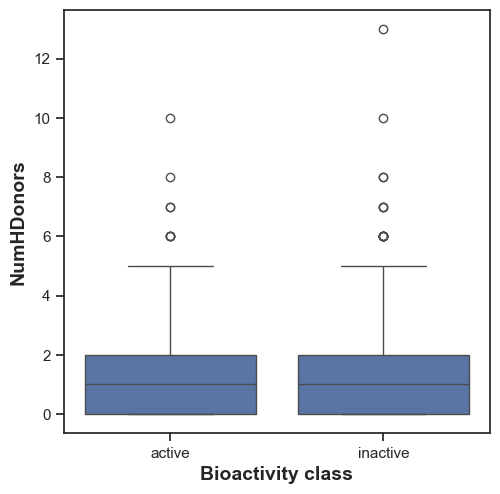

In [17]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHDonors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('./data/Part_2_Results/plot_NumHDonors.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [18]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,4979928.5,7.032845e-09,0.05,Different distribution (reject H0)


#### **NumHAcceptors**

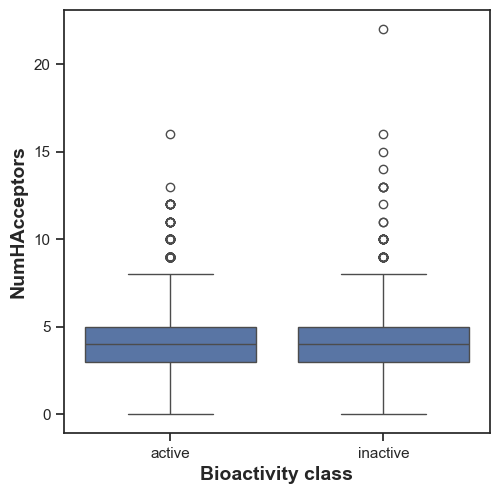

In [19]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHAcceptors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('./data/Part_2_Results/plot_NumHAcceptors.pdf')

In [20]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,4581438.0,0.766739,0.05,Same distribution (fail to reject H0)


#### **Interpretation of Statistical Results**

#### **Box Plots**
##### **pIC50 values**

Taking a look at pIC50 values, the active vs inactive compounds displayed ***statistically significant differences***, which is to be expected since pIC50 thresholds were used to define active and inactive classes (``pIC50 > 6 = active`` and ``pIC50 < 5 = inactive``). 

##### **Lipinski's descriptors**

Of the 4 Lipinski's descriptors (MW, LogP, NumHDonors and NumHAcceptors),all four exhibited ***statistically significant differences*** between the active and inactive bioactivity classes, with MannWhitney-U results rejecting the null hypothesis.

## **Zip files**

In [21]:
! zip -r results.zip . -i Part_2_Results

'zip' is not recognized as an internal or external command,
operable program or batch file.
